#### Load Required Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
np.random.seed(7)

### Basic Idea Behind Gaussian Processes (GP):  Visualizing Random Samples from a Multivariate Gaussian as Lines

A Gaussian process (GP) defines a distribution over functions $p(f)$, which can be used for Bayesian regression, with
$$ p(f|D) = \frac{p(f)p(D|f)}{p(D)}$$
In comparison, a Gaussian distribution $N(\mu, \Sigma)$ is a distribution over vectors and is fully specified by a mean $\mu$ and covariance $\Sigma$, whereas a Gaussian process $GP(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x'}))$ is a distribution over functions that is fully specified by a mean function $m(\mathbf{x})$ and a covariance function $k(\mathbf{x}, \mathbf{x'})$.

Furthermore, a GP directly places a prior over the space of possible functions $f$ instead of parameterizing $f$.  This non-parametric nature of GPs is what makes them more general than standard logistic regression, since they are not constrained by a chosen parametric form.

The goal of GPs is to predict function values $f_* = f(\mathbf{x}_*)$, along with corresponding errors/uncertainty $\sigma_*$, for all possible input values $\mathbf{x}$, given only a finite number of examples in a training data set $D = \{(\mathbf{x_i}, f_i), i=1, \ldots, N \}$.

#### Defining a mean function and covariance matrix

To apply GPs for regression, we need to define a mean function $m(\mathbf{x})$ and covariance function $k(\mathbf{x}, \mathbf{x'})$.  It is assumed that $m(\mathbf{x}) = \mathbf{0}$, since the training data can be normalized to zero by simply subtracting the mean from the data.

To construct a covariance matrix, we use a squared exponential kernel, defined by
$$ k(\mathbf{x}, \mathbf{x'}) = \exp(-||\mathbf{x}-\mathbf{x'}||^2) , $$
This kernel gives a correlation matrix where points that are closer to each other have a larger correlation than points that are farther from each other.

In [14]:
# squared exponential kernel
def sqrExpKernel(a, b, l, sf):
    na = len(a)
    nb = len(b)
    K = np.zeros((na,nb))
    for i in np.arange(na):
        for j in np.arange(nb):
            K[i, j] = sf**2*np.exp(-0.5*(a[i] - b[j])**2.0/l**2)
    return K

# function for plotting lines corresponding to sample points in joint Gaussian distribution
def plotFunc(xTrue=None, yTrue=None, xTrain=None, yTrain=None, xTest=None, muS=None, std=None, sampleLinesX=None, sampleLines=None, save=False, fileName='figure'):
    # plot graph
    fig = plt.figure(0, figsize=(8,5))
    ax = plt.subplot(1,1,1)
    if (xTrue is not None):
        plt.plot(xTrue, yTrue, ls='--', color='k')
    if (xTrain is not None):
        plt.plot(xTrain, yTrain, ls='None', color='r', marker='o', mec='r', mfc='r')
    if (xTest is not None):
        plt.fill(np.concatenate([xTest.reshape(1,-1).T, xTest.reshape(1,-1).T[::-1]]), 
                 np.concatenate([muS - std, (muS + std)[::-1]]), alpha=.3, fc='b', ec='None')
        plt.plot(xTest, muS, ls='--', color='b')
    if (sampleLines is not None):
        plt.plot(sampleLinesX, sampleLines)

    plt.xlabel('$X_i$')
    plt.ylabel('$f(X_i)$')
    if save:
        plt.savefig(fileName+".pdf", format='pdf')
    plt.show()

# function for plotting 2D conditional probability along with sample points
def plot2DProb(f, mu, covMat, d1=0, d2=1):
    X1, X2 = np.meshgrid(np.arange(-3, 3, 0.1), np.arange(-3, 3, 0.1))

    # plot
    fig = plt.figure(0, figsize=(10, 5))
    ax1 = plt.subplot(1,1,1)
    sigx1, sigx2 = np.sqrt(covMat[d1,d1]), np.sqrt(covMat[d2,d2])
    sigx1x2 = covMat[d1, d2]/(sigx1*sigx2)
    Z = mlab.bivariate_normal(X1, X2, sigmax=sigx1, sigmay=sigx2, mux=mu[d1], muy=mu[d2], sigmaxy=sigx1x2)
    plt.contour(X1, X2, Z, zorder=10, colors='r')
    plt.plot(f[d1,:], f[d2,:], ls='None', marker='o', markersize=4, mec='0.4', mfc='0.8', mew=0.5)
    plt.axis('scaled')
    plt.xlabel('X{:d}'.format(d1))
    plt.ylabel('X{:d}'.format(d2))
    plt.show()

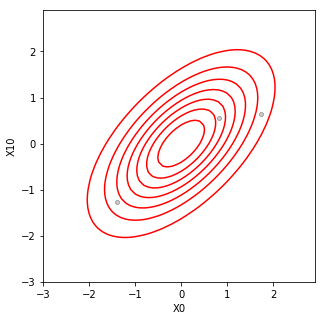

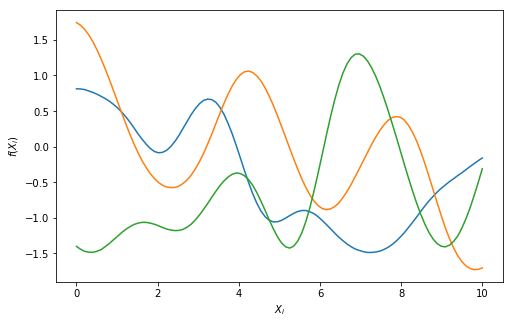

In [15]:
# construct test array specifying number of query points (dimension of joint Gaussian will be of nTest)
nTest = 100
xTest = np.linspace(0,10,nTest).reshape(-1,1)

# calculate covariance matrix of joint Gaussian
K = sqrExpKernel(xTest, xTest, 1.0, 1.0)

# assume zero mean for each dim of joint Gaussian
mu = np.zeros(nTest)

# calculate Cholesky decomposition of covariance matrix
L = np.linalg.cholesky(K + 1e-6*np.eye(nTest))

# sample points
nSamples = 3
fPrior = np.dot(L, np.random.normal(size=(nTest, nSamples)))

# sample from joint distribution and plot
plot2DProb(fPrior, mu, K, d1=0, d2=10)
plotFunc(sampleLinesX=xTest, sampleLines=fPrior)

## Noiseless GP Regression

To do noiseless GP regression, it is necessary to calculate
$$\mu_* = \overline{f_*} = \mathbf{k}_*^T\mathbf{K}^{-1}\mathbf{y}$$
at each query point, where $\mathbf{y}$ is simply the function values of the training data. Since $\mathbf{K}$ is not properly constrained, calculating the inverse of this matrix becomes unstable.  A better approach is the following:
* Apply Cholesky decomposition to $\mathbf{K}$ to obtain $\mathbf{L}$
$$ \mathbf{K} = \mathbf{L}\mathbf{L}^{T} $$
* Define $\alpha$ as follow, and substitute for $\mathbf{K}$:
$$\alpha = \mathbf{K}^{-1}\mathbf{y} = \mathbf{L}^{-T}\mathbf{L}^{-1}\mathbf{y}$$
* Let $\mathbf{m} = \mathbf{L}^{-1}\mathbf{y}$, so that
$$\mathbf{L m} = \mathbf{y}$$
is a linear system of equations from which $m$ can be solved.
* This gives $\mathbf{\alpha} = \mathbf{L}^{-T}\mathbf{m}$, so that
$$ \mathbf{L}^T \alpha = \mathbf{m} $$
is another linear system of equations from which $\mathbf{\alpha}$ can be solved.

A similar approach can be followed to calculate $\Sigma_{*}$ from the equation
$$ \Sigma_{*} = \mathbf{K}_{**} - \mathbf{K}_*^T\mathbf{K}^{-1}\mathbf{K}_*$$


### Training data

First we need to come up with some training data.  This can be done by constructing an arbitrary nonlinear function to serve as the underlying ground truth, and then rondomly sample points from this function.

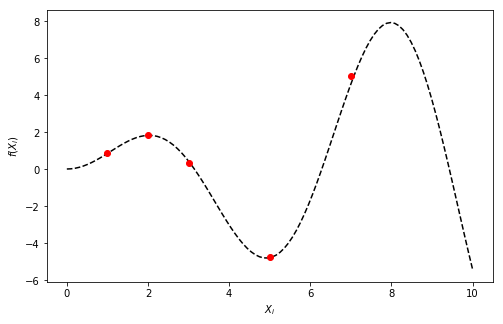

In [16]:
# create data to serve as the true underlying function
nTrue = 100
xTrue = np.linspace(0,10,nTrue)
# define an arbitrary function to be the ground truth
def func(x):
    return  np.sin(1*x)*x
yTrue = func(xTrue)

# randomly sample points from the true function for a training set
nTrain = 5
#xTrain = np.sort(np.random.choice(xTrue, nTrain, replace=False))
xTrain = np.array([1,2,3,5,7])
yTrain = yTrue[xTrue.searchsorted(xTrain)]

# standardize the training data by subtracting the mean (and adjust the ground truth accordingly)
#yTrain = yTrain - yTrain.mean()

# test set
nTest = 100
xTest = np.copy(xTrue)

# plot function and training set
plotFunc(xTrue=xTrue, yTrue=yTrue, xTrain=xTrain, yTrain=yTrain)

### Calculate $\mu_*$ and $\Sigma_*$ Using Training Data

Apply Gaussian Processes for regression to estimate the true function (dashed black line), by only using the training data (red points).

In [17]:
# construct matrices K, K_*, K_** using kernel2
hls = 1.0
vvar = 1.0
K = sqrExpKernel(xTrain.reshape(-1,1), xTrain.reshape(-1,1), hls, vvar)
Ks = sqrExpKernel(xTrain.reshape(-1,1), xTest.reshape(-1,1), hls, vvar)
Kss = sqrExpKernel(xTest.reshape(-1,1), xTest.reshape(-1,1), hls, vvar)

# calculate Cholesky decomposition of K
L = np.linalg.cholesky(K + 0.00005*np.eye(nTrain))

# calculate the predicted mean for the test points
m = np.linalg.solve(L, yTrain)
alpha = np.linalg.solve(L.T, m)
muS = np.dot(Ks.T, alpha)

# calculate the covariance matrix for the test points
v = np.linalg.solve(L, Ks)
sigmaS = Kss - np.dot(v.T, v)
stdv = np.sqrt(sigmaS.diagonal())

In [26]:
# draw samples from posterior distribution using sigmaS and muS
nSamples = 5
LPost = np.linalg.cholesky(sigmaS + 1e-6*np.eye(nTest))
fPost = muS.reshape(-1,1) + np.dot(LPost, np.random.normal(size=(nTest, nSamples)))

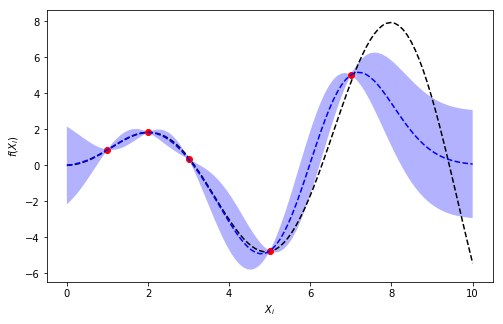

In [34]:
# plot 2D gaussian using 1st and last dim
#plot2DProb(fPost, muS, sigmaS, d1=0, d2=10)
#plotFunc(xTrue, yTrue, xTrain, yTrain, xTest, muS, stdv, sampleLinesX=xTest, sampleLines=fPost, save=False, fileName='figure')
plotFunc(xTrue, yTrue, xTrain, yTrain, xTest, muS, 3*stdv, save=False, fileName='figure')

## Noisy GP Regression

In order to perform GP regression with the knowledge that the training data is noisy observations, we consider the following form of the function we want to estimate:
$$ y = f(x) + \epsilon $$
with $\epsilon \sim N(0, \sigma_y^2)$.

In [47]:
# squared exponential kernel
def sqrExpKernelNoise(a, b, l, sf, sy):
    na = len(a)
    nb = len(b)
    K = np.zeros((na,nb))
    for i in np.arange(na):
        for j in np.arange(nb):
            K[i, j] = sf*np.exp(-0.5*(a[i] - b[j])**2.0/l) + sy*int(i==j)
    return K

In [48]:
# construct matrices K, K_*, K_** using kernel2
hls = 1.0
vvar = 1.0
nvar = 0.001
K = sqrExpKernelNoise(xTrain.reshape(-1,1), xTrain.reshape(-1,1), hls, vvar, nvar)
Ks = sqrExpKernelNoise(xTrain.reshape(-1,1), xTest.reshape(-1,1), hls, vvar, nvar)
Kss = sqrExpKernelNoise(xTest.reshape(-1,1), xTest.reshape(-1,1), hls, vvar, nvar)

# calculate Cholesky decomposition of K
L = np.linalg.cholesky(K + 1e-6*np.eye(nTrain))

# calculate the predicted mean for the test points
m = np.linalg.solve(L, yTrain)
alpha = np.linalg.solve(L.T, m)
muS = np.dot(Ks.T, alpha)

# calculate the covariance matrix for the test points
v = np.linalg.solve(L, Ks)
sigmaS = Kss - np.dot(v.T, v)
stdv = np.sqrt(sigmaS.diagonal())

In [49]:
# draw samples from posterior distribution using sigmaS and muS
nSamples = 5
LPost = np.linalg.cholesky(sigmaS + 1e-6*np.eye(nTest))
fPost = muS.reshape(-1,1) + np.dot(LPost, np.random.normal(size=(nTest, nSamples)))

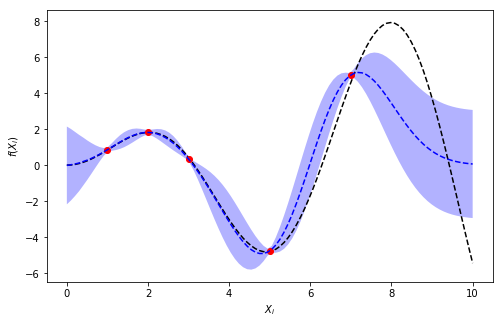

In [50]:
# plot 2D gaussian using 1st and last dim
#plot2DProb(fPost, muS, sigmaS, d1=0, d2=10)
plotFunc(xTrue, yTrue, xTrain, yTrain, xTest, muS, 3*stdv, save=False, fileName='figure')

### Comparison with pyGPs

In [51]:
import pyGPs as pg

In [52]:
# initialize pyGPs regression model
pgModel = pg.GPR()
# get default model setup with zero mean and radial basis function (RBF) for the kernel
pgModel.setNoise( log_sigma = np.log(0.001) )
pgModel.getPosterior(xTrain, yTrain)

pgModel.predict(xTest);

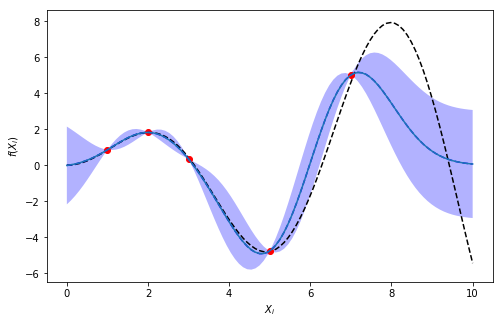

In [55]:
plotFunc(xTrue, yTrue, xTrain, yTrain, xTest, pgModel.ym, 3*np.sqrt(pgModel.ys2), sampleLinesX=xTest, sampleLines=muS, save=False, fileName='figure')